In [43]:
!ls ../input/shopee-generate-data-for-triplet-loss/train_triplets_imgs.csv
!ls ../input/shopee-product-matching/

../input/shopee-generate-data-for-triplet-loss/train_triplets_imgs.csv
sample_submission.csv  test.csv  test_images  train.csv  train_images


In [44]:
import sys
sys.path.append ('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')

import os
import gc
import time
import math
import random
import datetime
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
from   torch.nn import init
from   torch.nn import CrossEntropyLoss, MSELoss
from   torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
from   torch.nn import Parameter
from   torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from   transformers import AdamW, get_cosine_schedule_with_warmup
from   torch.cuda.amp import autocast, GradScaler

from   fastai.losses import LabelSmoothingCrossEntropy

# from warmup_scheduler import GradualWarmupScheduler
from   sklearn import preprocessing
from   sklearn.metrics import accuracy_score
from   sklearn.model_selection import StratifiedKFold, GroupKFold
from   sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score
from   sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

import timm
import albumentations as A
from   albumentations import *
from   albumentations.pytorch import ToTensorV2
from   albumentations.core.transforms_interface import DualTransform
from   albumentations.augmentations import functional as AF
import cv2

from   tqdm import tqdm
from   pprint import pprint
from   functools import partial
import matplotlib.pyplot as plt
# from GPUtil import showUtilization as gpu_usage
from   numba import cuda
import warnings
warnings.filterwarnings ("ignore")

In [45]:
class CFG:
    device       = torch.device ('cuda' if torch.cuda.is_available () else 'cpu')
    num_workers  = 8
    use_fc       = False    
    model_name   = 'efficientnet_b3'      # ['deit_base_patch16_224', 'vit_base_patch16_384', 'resnext50_32x4d', 'tf_efficientnet_b7_ns']
    n_classes    = 512                    # 11014
    fc_dim       = 0
    dropout      = 0.0
    s            = 30.0
    margin       = 0.50
    ls_eps       = 0.0
    theta_zero   = 0.785
    pretrained   = True
        
    size         = 384                     # [64, 128, 224, 384, 512, 640, 720]
    isTrain      = True
    isFreeze     = True
    lr           = 1e-3
    epochs       = 6
    warmup_steps = 0.50                    # if float: these many epochs are with frozen model at the beginning, if int = actual steps
    lr_num_cycles= 2.5
    epochsNx     = 1
    # criterion  = 'dice_bce'              # ['dice_bce', CrossEntropyLoss', 'BCEWithLogitsLoss', 'SmoothBCEwithLogits']
    weight_decay = 1e-6
    max_grad_norm= 1000.0
    seed         = 42
    n_fold       = 10
    train_fold   = [0]                      # [0, 1, 2, 3, 4]
    print_every  = 100
    adam_epsilon = 1e-8
    train_batch_size = 12
    eval_batch_size  = 12    
    model_infer_path_prefix = "."
    model_train_path_prefix = "."
    img_triplets_csv = "../input/shopee-generate-data-for-triplet-loss/train_triplets_imgs.csv"
    train_path       = '../input/shopee-product-matching/train_images'
    # train_csv        = '../input/vinbigdata-chest-xray-abnormalities-detection/train.csv'
    # test_path        = '../input/vinbigdata-chest-xray-resized-png-1024x1024/test'
    output_dir       = './results'        # output directory    
    eval_steps       = 0                  # if float: these many epochs are with frozen model at the beginning, if int = actual steps 
    max_steps        = 0
    MODEL            = None

In [46]:
def init_logger (log_file=CFG.output_dir+'train.log'):
    
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger (__name__)
    logger.setLevel (INFO)
    handler1 = StreamHandler ()
    handler1.setFormatter (Formatter ("%(message)s"))
    handler2 = FileHandler (filename=log_file)
    handler2.setFormatter (Formatter ("%(message)s"))
    logger.addHandler (handler1)
    logger.addHandler (handler2)
    return logger

In [47]:
def seed_everything (seed):
    
    random.seed (seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed (seed)
    torch.manual_seed (seed)
    torch.cuda.manual_seed (seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    return

# Image Augmentations

In [48]:
def get_transforms (data='train'):
    
    light_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        # A.HorizontalFlip (p=0.5),
        A.OneOf([
            A.CLAHE (clip_limit=(1,4), p=1),
            A.HueSaturationValue (hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=1),
            A.RandomBrightnessContrast (brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=1),
            A.augmentations.transforms.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
        ], p=0.5),
        # A.augmentations.transforms.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
        A.augmentations.transforms.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
        A.CoarseDropout(p=0.5),
        # A.Cutout (max_h_size=int(CFG.size * 0.2), max_w_size=int(CFG.size * 0.2), num_holes=2, p=0.75),
        A.Normalize (),
        ToTensorV2 (p=1.0),
    ])
    
    valid_transforms = A.Compose ([
        A.Resize (CFG.size, CFG.size),
        A.Normalize (),
        ToTensorV2 (p=1.0),
    ])
    
    if 'train' in data:
        return light_transforms
    elif 'valid' in data:
        return valid_transforms
    return valid_transforms

# Dataset

In [49]:
# see image triplets
df = pd.read_csv (CFG.img_triplets_csv)
TRAIN_DF = df.iloc[:(df.shape[0]*9//10)]
TEST_DF  = df.iloc[(df.shape[0]*9//10):]
del df
gc.collect ()
TEST_DF.head ()

,anchor,positive,negative
30825,e6cacdc399322158ca9c980a9ab42aee.jpg,260791f572b37106e450d3e2f0dc3913.jpg,4f79e786a57476a6ef4375db3e56d4e1.jpg
30826,e6cd3179799b0caba2e1c57a08c5af59.jpg,8a11943162871a5ed71ba4c189de89c4.jpg,9d396f45de57830007f23fd15864e414.jpg
30827,e6d0ca2b793deb5eb4d7970562bbae7e.jpg,e58796b518c5fca3ca8334c257895270.jpg,1ff53e5c857b0a268ada8c653887cf2b.jpg
30828,e6d2fe7f2b3c65f56b3fae0f1150751f.jpg,b8f46bbdeb234ec709bbaafe7cc9d614.jpg,cc496b883895b6b13189a151c068991c.jpg
30829,e6d692b7106bc7ef5cf401e6e7de76f7.jpg,25bf5187ef525acb1e92f03b65f745ce.jpg,ed31b2cd62b26f810121c81b97c61f0f.jpg


In [50]:
class TripletImageDataset (Dataset):
    
    def __init__(self, df=TRAIN_DF, 
                 transform=get_transforms ('train')):
        self.df = df # pd.read_csv (img_triplets_csv).reset_index (drop=True)
        self.transform = transform
        
    def __getitem__(self, index):
        
        triplet  = self.df.iloc[index]
        anchor   = self.transform (image=cv2.imread (f"{CFG.train_path}/{triplet['anchor']}"))['image']
        positive = self.transform (image=cv2.imread (f"{CFG.train_path}/{triplet['positive']}"))['image']
        negative = self.transform (image=cv2.imread (f"{CFG.train_path}/{triplet['negative']}"))['image']
        return (anchor, positive, negative)
    
    def __len__(self):
        return self.df.shape[0]

82

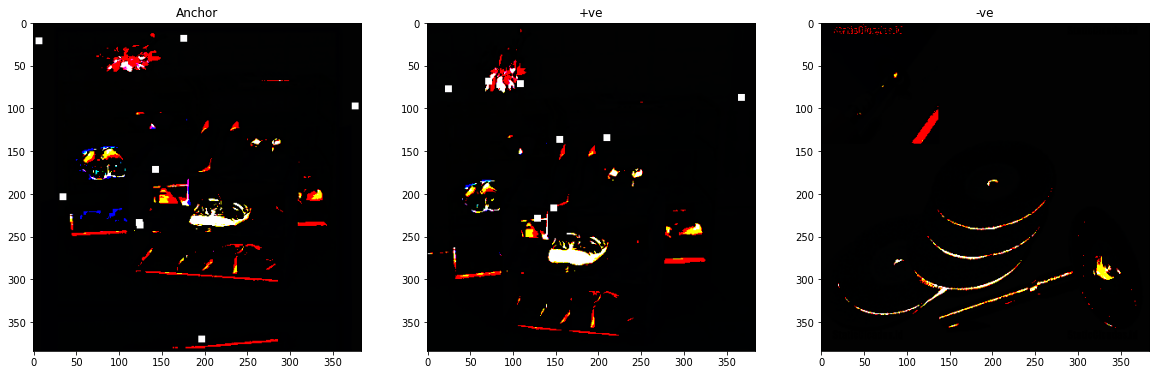

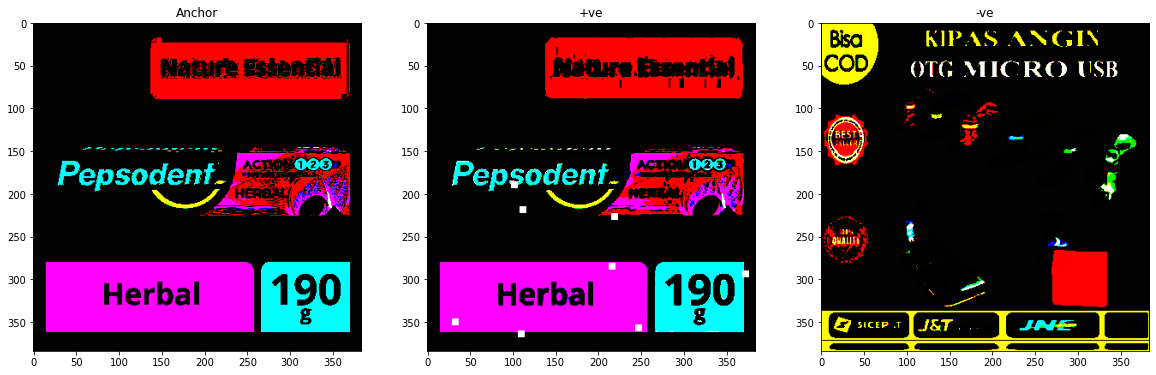

In [51]:
def plot_imgs (dataset_show):
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 20,10
    for i in range (2):
        f, axarr = plt.subplots (1,3)
        for p in [0]:
            idx = np.random.randint (0, len (dataset_show))
            img1, img2, img3 = dataset_show[idx]                         # ;print (img.size()) ;print (label)
            img1 = img1.byte ()
            img2 = img2.byte ()
            img3 = img3.byte ()
            axarr[p].imshow (img1.permute(1, 2, 0))
            axarr[p].set_title ('Anchor')
            axarr[p+1].imshow (img2.permute(1, 2, 0))
            axarr[p+1].set_title ('+ve')
            axarr[p+2].imshow (img3.permute(1, 2, 0))
            axarr[p+2].set_title ('-ve')
    return

TR_DATASET = TripletImageDataset ()
plot_imgs (TR_DATASET)
del TR_DATASET
gc.collect ()

# Model

In [52]:
class ShopeeNet (nn.Module):

    def __init__(self,
                 n_classes=CFG.n_classes,
                 model_name=CFG.model_name,
                 use_fc=CFG.use_fc,
                 fc_dim=CFG.fc_dim,
                 dropout=CFG.dropout,
                 s=CFG.s,
                 margin=CFG.margin,
                 ls_eps=CFG.ls_eps,
                 theta_zero=CFG.theta_zero,
                 pretrained=CFG.pretrained):
        """
        :param n_classes:
        :param model_name: name of model from pretrainedmodels
            e.g. resnet50, resnext101_32x4d, pnasnet5large
        """
        super(ShopeeNet, self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))
        
        self.backbone = timm.create_model (model_name, pretrained=pretrained)
        final_in_features = self.backbone.classifier.in_features
        
        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()
        
        self.pooling =  nn.AdaptiveAvgPool2d(1)
        
        self.use_fc = use_fc
        if use_fc:
            self.dropout = nn.Dropout(p=dropout)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim
        
        self.final = nn.Linear (final_in_features, n_classes)
    
    def freeze (self):
        
        for param in self.parameters ():
            param.requires_grad = False        
        for param in self.backbone.parameters ():
            param.requires_grad = False
        
        for param in self.final.parameters ():
            param.requires_grad = True
        if self.use_fc:
            for param in self.fc.parameters ():
                param.requires_grad = True
            for param in self.bn.parameters ():
                param.requires_grad = True
        return
    
    def unfreeze (self):
        
        for param in self.backbone.parameters ():
            param.requires_grad = True
        for param in self.parameters ():
            param.requires_grad = True
            
        for param in self.final.parameters ():
            param.requires_grad = True
        if self.use_fc:
            for param in self.fc.parameters ():
                param.requires_grad = True
            for param in self.bn.parameters ():
                param.requires_grad = True
        return
    
    def _init_params (self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)
    
    def forward(self, x):
        feature = self.extract_feat (x)
        logits = self.final (feature)
        return logits
    
    def extract_feat (self, x):
        batch_size = x.shape[0]
        x = self.backbone (x)
        x = self.pooling (x).view (batch_size, -1)

        if self.use_fc:
            x = self.dropout (x)
            x = self.fc (x)
            x = self.bn (x)

        return x

In [53]:
class TripletModel (nn.Module):
    
    def __init__(self, embeddingModel):
        
        super (TripletModel, self).__init__()
        self.embeddingModel = embeddingModel
    
    def forward (self, i1, i2, i3):
        
        E1 = self.embeddingModel (i1)
        E2 = self.embeddingModel (i2)
        E3 = self.embeddingModel (i3)
        return E1, E2, E3
    
    def freeze (self):        
        self.embeddingModel.freeze ()
        return
    
    def unfreeze (self):
        self.embeddingModel.unfreeze ()
        return

> # Loss Functions

In [54]:
def get_criterion (margin):
    
    criterion = nn.MarginRankingLoss (margin=margin)
    return criterion

In [55]:
def load_state (model_path, model):
    
    state_dict = None
    try:  # single GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))['state_dict']
        # print (state_dict)
        state_dict = fix_state_dict (state_dict)
        model.load_state_dict (state_dict) # (torch.load (model_path, map_location=torch.device ('cpu')), strict=True)
    except:  # multi GPU model_file
        state_dict = torch.load (model_path, map_location=torch.device ('cpu'))
        state_dict = {k[7:] if k.startswith ('module.') else k: state_dict[k] for k in state_dict.keys ()}
        model.load_state_dict (state_dict)
    return state_dict

In [56]:
def getModel (fold, isTrain=True):
    
    model = ShopeeNet ()
    if isTrain:
        
        # model_path = f'{CFG.model_train_path_prefix}/{CFG.model_name}_fold{fold}_start.pth'        
        # print ("loading", model_path)
        # load_state (model_path, model)
        pass
    else:
        
        # model_path = f'{CFG.model_infer_path_prefix}/{CFG.model_name}_fold{fold}_maxacc.pth'
        # load_state (model_path, model)
        pass
    
    # torch.save (model.state_dict (), model_path)
    
    # Warp as model for triples
    model = TripletModel (model)
    
    if CFG.isFreeze:        
        model.freeze ()
    else:
        model.unfreeze ()
    
    return model

## Trainer Helpers

In [57]:
def format_time (elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str (datetime.timedelta (seconds=elapsed_rounded))

# Trainer

In [58]:
class MyTrainer:
    
    def __init__(self, fold, model, train_dataset, eval_dataset, criterion, 
                 checkpoint_path=None, isResume=False):
        
        self.fold             = fold
        self.start_epoch      = 0
        self.model            = model
        # load checkpoint
        if checkpoint_path is not None:
            if isResume:
                self.start_epoch = self.load_checkpoint (checkpoint_path, isResume=True) + 1
            else:
                self.load_checkpoint (checkpoint_path, isResume=False)
        self.model            = self.model.to (CFG.device)
        if CFG.isFreeze:
            self.model.freeze ()
        else:
            self.model.unfreeze ()
        CFG.MODEL             = self.model
        self.train_dataset    = train_dataset
        self.eval_dataset     = eval_dataset
        self.criterion        = criterion
        self.isTrained        = False
        self.device           = CFG.device
        self.optimizer        = AdamW (self.model.parameters (), lr=CFG.lr, eps=CFG.adam_epsilon, weight_decay=CFG.weight_decay)
        self.epochs           = CFG.epochs
        self.set_dataLoaders ()
        self.training_stats   = []
        self.modelFile        = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}.pth"
        if eval_dataset is not None:
            self.minLossModelFile = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_min_val_loss.pth"
            self.maxAccModelFile  = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_max_val_acc.pth"
        else:
            self.minLossModelFile = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_min_tr_loss.pth"
            self.maxAccModelFile  = f"{CFG.model_train_path_prefix}/{CFG.model_name}_{CFG.size}_fold{self.fold}_max_tr_acc.pth"
        
        self.min_val_loss         = 9999
        self.min_train_loss       = 9999
        self.max_val_acc          = -1    
        return
    
    def set_dataLoaders (self):
        # Create the DataLoaders for our training and validation sets.
        
        if isinstance (self.train_dataset, torch.utils.data.IterableDataset):
            train_sampler = None
        else:
            train_sampler = RandomSampler (self.train_dataset)           # Better use RandomSampler
        train_dataloader  = DataLoader (
                    self.train_dataset,                                  # The training samples.
                    sampler     = train_sampler,                           
                    batch_size  = CFG.train_batch_size,
                    num_workers = CFG.num_workers,
                    pin_memory  = True
        )
        # train_dataloader  = DataLoader (self.train_dataset, batch_size=CFG.train_batch_size) # TODO: comment this
        validation_dataloader = None
        if self.eval_dataset:
            validation_dataloader = DataLoader (
                        self.eval_dataset, 
                        sampler     = SequentialSampler (self.eval_dataset),
                        batch_size  = CFG.eval_batch_size,
                        num_workers = CFG.num_workers,
                        pin_memory  = False
            )
            # validation_dataloader  = DataLoader (self.eval_dataset, batch_size=CFG.eval_batch_size) # TODO: comment this
        
        if type (CFG.warmup_steps) is float:
            CFG.warmup_steps = int (CFG.warmup_steps * len (train_dataloader))
        # Total number of training steps is [number of batches] x [number of epochs]
        num_training_steps = len (train_dataloader) * self.epochs        
        lr_scheduler = get_cosine_schedule_with_warmup (self.optimizer, num_cycles=CFG.lr_num_cycles,
                        num_warmup_steps=CFG.warmup_steps, num_training_steps=num_training_steps)
        
        if type (CFG.eval_steps) is float:
            CFG.eval_steps = int (CFG.eval_steps * len (train_dataloader))
        self.train_dataloader, self.validation_dataloader, self.lr_scheduler, self.num_training_steps=train_dataloader, validation_dataloader, lr_scheduler, num_training_steps
        return
            
    def test_iterate_dataloader (self):
        
        for step, batch in enumerate (self.train_dataloader):
            print (step)
            print (batch)
            break
        return
    
    def save_checkpoint (self, epoch, path):
        
        checkpoint = {
            'epoch'               : epoch,
            'model_state_dict'    : self.model.state_dict (),
            'optimizer_state_dict': self.optimizer.state_dict (),
            'lr_sched_state_dict' : self.lr_scheduler.state_dict (),
            'training_stats'      : self.training_stats,
            'max_val_acc'         : self.max_val_acc,
            'min_train_loss'      : self.min_train_loss,
            'min_val_loss'        : self.min_val_loss,
        }
        torch.save (checkpoint, path)
        gc.collect (); torch.cuda.empty_cache ()
        print ("saved checkpoint", path)
        return
    
    def load_checkpoint (self, path, isResume=False):
        
        epoch      = 0
        checkpoint = torch.load (path, map_location=torch.device ('cpu'))
        self.model.load_state_dict (checkpoint['model_state_dict'])
        if isResume:
            
            self.optimizer.load_state_dict (checkpoint['optimizer_state_dict'])
            self.lr_scheduler.load_state_dict (checkpoint['lr_sched_state_dict'])
            epoch = checkpoint['epoch']
            self.training_stats  = checkpoint['training_stats']
            self.min_val_loss    = checkpoint['min_val_loss']
            self.min_train_loss  = checkpoint['min_train_loss']
            self.max_val_acc     = checkpoint['max_val_acc']
            print ("Loaded model, optimizer, and lr_scheduler from -", path)
        else:
            print ("Loaded model from -", path)
            
        self.model.train ()
        return epoch
    
    def train (self):
        
        seed_everything (seed=CFG.seed)
        step             = 0
        total_t0         = time.time ()
        scaler           = GradScaler()
        for epoch_i in range (self.start_epoch, self.epochs):
            
            avg_epoch_train_loss   = 0
            total_epoch_train_loss = 0
            print('======== Epoch {:} / {:} ========'.format (epoch_i + 1, self.epochs))
            t0 = time.time ()
            self.model.train ()
            for stp, batch in tqdm (enumerate (self.train_dataloader), total=len(self.train_dataloader)):
                
                # Print Stats
                # if step % CFG.print_every == 0:
                #     elapsed = format_time (time.time() - t0)
                #     print ('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format (step, len (self.train_dataloader), elapsed))                
                if ((CFG.max_steps > 0 and CFG.max_steps < step) or 
                    (CFG.eval_steps>0 and stp==CFG.eval_steps)): # or step==0):   # TODO: rm this comment
                    
                    self.save_checkpoint (epoch_i, self.modelFile)
                    training_time = format_time (time.time () - t0)            
                    if self.validation_dataloader:
                        
                        avg_val_loss, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                        # save this model if the eval loss decreases from the minimum so far
                        checkpoint_epoch = epoch_i
                        if stp==CFG.eval_steps:
                            # don't count this epoch in the checkpoint since this epoch 
                            # has not completed. Hence, checkpoint at prev epoch
                            checkpoint_epoch = epoch_i-1
                        if avg_val_loss < self.min_val_loss:                             
                            self.min_val_loss = avg_val_loss
                            self.save_checkpoint (checkpoint_epoch, self.minLossModelFile)
                        if avg_val_accuracy > self.max_val_acc:
                            self.max_val_acc = avg_val_accuracy
                            self.save_checkpoint (checkpoint_epoch, self.maxAccModelFile)
                    if CFG.max_steps > 0 and CFG.max_steps < step:
                        
                        print ("")
                        print ("Training complete!")
                        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
                        self.isTrained = True
                        self.model.cpu ()
                        self.model.eval ()
                        self.save_checkpoint (epoch_i, self.modelFile)
                        try:
                            torch.cuda.empty_cache ()
                            self.plot_train_stats (self.training_stats)
                        except:
                            pass
                        return pd.DataFrame (self.training_stats)
                
                ########################################################
                # Train
                ########################################################
                # self.model.zero_grad ()
                anc_imgs = batch[0].to (self.device)
                pos_imgs = batch[1].to (self.device)
                neg_imgs = batch[2].to (self.device)
                with autocast():
                    
                    E1, E2, E3 = self.model (anc_imgs, pos_imgs, neg_imgs)
                    dist_E1_E2 = F.pairwise_distance (E1, E2, 2)
                    dist_E1_E3 = F.pairwise_distance (E1, E3, 2)
                    target = torch.FloatTensor (dist_E1_E2.size()).fill_ (-1)
                    target = target.to (CFG.device)
                    loss = self.criterion (dist_E1_E2, dist_E1_E3, target)
                    scaler.scale (loss).backward ()
                    torch.nn.utils.clip_grad_norm_ (self.model.parameters (), CFG.max_grad_norm)
                    scaler.step (self.optimizer)
                    scaler.update ()
                    self.optimizer.zero_grad ()
                    self.lr_scheduler.step ()
                    
                total_epoch_train_loss += loss.cpu ().item ()
                avg_epoch_train_loss    = total_epoch_train_loss / (stp+1)
                step += 1
            # all steps of an epoch end
            
            # Measure how long this epoch took.
            training_time = format_time (time.time () - t0)            
            print ("  Average training loss: {0:.4f}".format (avg_epoch_train_loss))
            print ("  Training epcoh took: {:}".format (training_time))            
            if self.validation_dataloader:    
                
                avg_val_loss, avg_val_accuracy, validation_time = self.evaluate (epoch_i, avg_epoch_train_loss, training_time)
                # save this epoch's model if the eval loss decreases from the minimum so far
                if avg_val_loss < self.min_val_loss:                    
                    self.min_val_loss = avg_val_loss
                    self.save_checkpoint (epoch_i, self.minLossModelFile)
                if avg_val_accuracy > self.max_val_acc:
                    self.max_val_acc = avg_val_accuracy
                    self.save_checkpoint (epoch_i, self.maxAccModelFile)
            else:                
                training_stats.append ({
                    'epoch'         : epoch_i + 1,
                    'training_loss' : avg_epoch_train_loss,
                    'training_time' : training_time,
                })
                if avg_train_loss < self.min_train_loss:                     
                    self.min_train_loss = avg_train_loss
                    self.save_checkpoint (epoch_i, self.minLossModelFile)
            self.save_checkpoint (epoch_i, self.modelFile)
            # 1 epoch end
        # all epochs end
        
        # just get the best class thresholds at the end
        if self.validation_dataloader:
            print ('At training end, threshold Adjustment (last row of the train summary DF)')
            print (self.evaluate (epoch_i, avg_epoch_train_loss, training_time, isThreshAdjust=True))
            print ('<: avg_val_loss, avg_val_accuracy, validation_time')
        
        print ("***** Training complete! *****")
        print ("Total training took {:} (h:mm:ss)".format (format_time (time.time ()-total_t0)))
        self.isTrained = True
        self.model.cpu ()
        self.model.eval ()
        try:
            torch.cuda.empty_cache ()
            self.plot_train_stats (self.training_stats)
        except:
            pass
        return pd.DataFrame (self.training_stats)
    
    def evaluate (self, epoch_i, avg_train_loss=999, training_time=999, isThreshAdjust=False):
        
        t0           = time.time ()
        all_labels   = []
        all_pred_prs = []
        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        self.model.eval ()
        
        # Tracking variables
        total_eval_accuracy  = 0
        total_eval_loss      = 0
        nb_eval_steps        = 0
        correct_pred_count   = 0
        total_pred_count     = 0
        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            with torch.no_grad ():
                
                anc_imgs = batch[0].to (self.device)
                pos_imgs = batch[1].to (self.device)
                neg_imgs = batch[2].to (self.device)                
                E1, E2, E3 = self.model (anc_imgs, pos_imgs, neg_imgs)
                dist_E1_E2 = F.pairwise_distance (E1, E2, 2)
                dist_E1_E3 = F.pairwise_distance (E1, E3, 2)
                target     = torch.FloatTensor (dist_E1_E2.size()).fill_ (-1).to (CFG.device)
                loss       = self.criterion (dist_E1_E2, dist_E1_E3, target).cpu ().detach ()
                
            correct_pred_count += sum ((dist_E1_E2 < dist_E1_E3) + 0.0)
            total_pred_count   += len (dist_E1_E2) 
            total_eval_loss    += loss.item ()     
        
        avg_val_loss     = total_eval_loss / len (self.validation_dataloader)
        avg_val_accuracy = correct_pred_count / total_pred_count
        print ("Val Loss: {0:.4f}".format (avg_val_loss))
        print ("Val Accuracy: {0:.4f}".format (avg_val_accuracy))
        validation_time = format_time (time.time () - t0)
        self.training_stats.append ({
                'epoch'         : epoch_i + 1,
                'training_loss' : avg_train_loss,
                'eval_loss'     : avg_val_loss,
                'eval_accuracy' : avg_val_accuracy,
                'training_time' : training_time,
                'eval_time'     : validation_time                   
        })
        self.model.train ()
        print ("Validation took {:} (h:mm:ss)".format (format_time (time.time () - t0)))
        return avg_val_loss, avg_val_accuracy, validation_time
        
        
    def plot_train_stats (self, training_stats):
        """
        Draw Classification Report curve
        """
        
        accuracies = eval_losses = tr_losses = epochs = -1
        epochs = len (training_stats)
        if 'eval_accuracy' in training_stats[0]:
            accuracies = [e['eval_accuracy'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=accuracies, label='val_accuracy')
        if 'eval_loss' in training_stats[0]:
            eval_losses= [e['eval_loss'] for e in training_stats]
        if 'training_loss'  in training_stats[0]:
            tr_losses  = [e['training_loss'] for e in training_stats]
            sns.lineplot (x=np.arange(1, epochs + 1), y=tr_losses,  label='tr_losses')
            
        plt.show ()
        print ('accuracies :', accuracies)        
        print ('eval_losses:', eval_losses)
        print ('tr_losses  :', tr_losses)
        return
    
    def get_trained_model (self):
        
        if self.isTrained:
            return self.model.eval ()
        return None

In [59]:
def free_gpu_cache ():
    
    # print("Initial GPU Usage")
    # gpu_usage()                             

    torch.cuda.empty_cache ()

    # cuda.select_device(0)
    # cuda.close()
    # cuda.select_device(0)

    # print("GPU Usage after emptying the cache")
    # gpu_usage()
    return

# free_gpu_cache()           

## Train

In [60]:
def train_fold_loop (checkpoint_path=None):

    print (f"========== training ==========")
    fold = 0 # fold is not used
    criterion      = get_criterion (CFG.margin)
    model          = CFG.MODEL
    if model is None and checkpoint_path is None:
        print ("CFG.MODEL is None")
        model      = getModel (fold, isTrain=True)
        model      = model.float()
    elif model is not None and checkpoint_path is not None:
        checkpoint_path = None
    elif model is None and checkpoint_path is not None:
        print ("CFG.MODEL is None")
        model      = getModel (fold, isTrain=False)
        model      = model.float()
        
    train_dataset  = TripletImageDataset ()
    valid_dataset  = TripletImageDataset (df=TEST_DF, transform=get_transforms ('valid'))
    trainer        = MyTrainer (
        fold            = fold,
        model           = model,
        train_dataset   = train_dataset,
        eval_dataset    = valid_dataset,
        criterion       = criterion,
        checkpoint_path = checkpoint_path
    )
    metrics = trainer.train ()
    return metrics
    
    # To plot lr uncomment this
    # lrs = []
    # for i in range (CFG.epochs*len (trainer.train_dataloader)):
    #     trainer.lr_scheduler.step ()
    #     lrs.append (trainer.optimizer.param_groups[0]["lr"])
    # print (lrs)
    # plt.plot (lrs)
    # plt.show ()

In [61]:
def train_main (checkpoint_path=None):
    
    print (f"========== train_main() ==========")
    if CFG.isTrain:        
        valid_scores_df = pd.DataFrame ()
        for fold in range (CFG.n_fold):
            if fold in CFG.train_fold:
                
                valid_scores_fold_df = train_fold_loop (checkpoint_path)
                # valid_scores_fold = np.array (valid_scores_fold).reshape ((1, -1))
                valid_scores_df = valid_scores_df.append (valid_scores_fold_df)
                
        print (f"========== CV ==========")
        # print (valid_scores_df)
        # valid_scores = np.vstack (valid_scores)
        # valid_scores = np.mean (valid_scores, axis=0)
        valid_scores = valid_scores_df.iloc[-1, :]  #.mean ()
        print ("CV Scores :-");  print (valid_scores)
    return valid_scores_df

# Single config training

!mkdir -p /kaggle/working/Output/
!touch /kaggle/working/Output/train.log
gc.collect ()
model_names = timm.list_models (pretrained=True)
model_names = timm.list_models ('*resnet*', pretrained=True)
pprint (model_names)
LOGGER = init_logger ()
seed_everything (seed=CFG.seed)

valid_scores_df = train_main ()

valid_scores_df

# To train, uncomment these

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.warmup_steps = 0.5
# CFG.eval_steps   = 0.5
CFG.num_workers  = 8
CFG.size = 128         # [128, 224, 384, 512, 640, 1024]
CFG.train_batch_size = 28
CFG.eval_batch_size  = 28
CFG.freeze = True
CFG.epochs = 1
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df = train_main () # (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_1024_fold0.pth")
valid_scores_df

***** Training for size=128 freeze=True *****
========== train_main() ==========
========== training ==========
CFG.MODEL is None
Building Model Backbone for efficientnet_b3 model


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


======== Epoch 1 / 1 ========


  0%|          | 4/1101 [02:31<11:15:04, 36.92s/it]

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.warmup_steps = 0.5
# CFG.eval_steps   = 0.5
CFG.num_workers = 8
CFG.size = 128
CFG.train_batch_size = 8
CFG.eval_batch_size  = 8
CFG.isFreeze = False
CFG.epochs = 5
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df = train_main ()
valid_scores_df

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 4
CFG.warmup_steps     = 0.5
# CFG.eval_steps       = 0.5
CFG.size             = 224
CFG.train_batch_size = 16
CFG.eval_batch_size  = 16
CFG.isFreeze         = True
CFG.epochs           = 2
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_224_fold0.pth")
valid_scores_df

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
# CFG.eval_steps       = 0.5
CFG.size             = 224
CFG.train_batch_size = 4
CFG.eval_batch_size  = 4
CFG.isFreeze         = False
CFG.epochs           = 5
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 4
CFG.warmup_steps     = 0.5
# CFG.eval_steps       = 0.5
CFG.size             = 384
CFG.train_batch_size = 8
CFG.eval_batch_size  = 8
CFG.isFreeze         = True
CFG.epochs           = 2
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_384_fold0.pth")
valid_scores_df

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
# CFG.eval_steps       = 0.5
CFG.size             = 384
CFG.train_batch_size = 4
CFG.eval_batch_size  = 4
CFG.isFreeze         = False
CFG.epochs           = 4
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main ()
valid_scores_df

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
# CFG.eval_steps       = 0.5
CFG.size             = 512
CFG.train_batch_size = 4
CFG.eval_batch_size  = 4
CFG.isFreeze         = True
CFG.epochs           = 1
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-cbamresnet50-384-fold0/cbam_resnet50_384_fold0.pth") 
valid_scores_df

In [ ]:
gc.collect (); torch.cuda.empty_cache ()
CFG.num_workers      = 8
CFG.warmup_steps     = 0.5
# CFG.eval_steps       = 0.5
CFG.size             = 512
CFG.train_batch_size = 4
CFG.eval_batch_size  = 4
CFG.isFreeze         = False
CFG.epochs           = 1
print (f"***** Training for size={CFG.size} freeze={CFG.isFreeze} *****")
valid_scores_df      = train_main () # (checkpoint_path="../input/vin-manual-torch-trainer-fp16-cbamresnet50-gradcam/cbam_resnet50_384_fold0.pth")
valid_scores_df

In [ ]:
print ('Done !')